In [1]:
import random
import pandas as pd
import numpy as np
import statistics
import matplotlib.pyplot as plt
from typing import Callable
from copy import deepcopy
import itertools
from tqdm import tqdm

In [2]:
SEED = 26
random.seed(SEED)
np.random.seed(SEED)

In [3]:
players_df = pd.read_csv("players(in).csv", index_col=0)

In [4]:
class Player():

    def __init__(self, player):
        self.name = player["Name"]
        self.position = player["Position"]
        self.skill = player["Skill"]
        self.salary = player["Salary (€M)"]

    def __repr__(self):
        return f"{self.name} - {self.position}"

    # para comparar jogadores com os mesmos dados
    def __eq__(self, other):
        if not isinstance(other, Player):
            return False
        return self.name == other.name and self.position == other.position

    def __hash__(self):  # NAO FACO A MINIMA
        return hash((self.name, self.position))

In [5]:
class Team():

    def __init__(self, name, budget):

        self.budget = budget
        self.name = name
        self.goalkeepers = []
        self.defenders = []
        self.midfielders = []
        self.forwards = []

    def add_player(self, player):
        if player.position == "GK":
            self.goalkeepers.append(player)
        if player.position == "DEF":
            self.defenders.append(player)
        if player.position == "MID":
            self.midfielders.append(player)
        if player.position == "FWD":
            self.forwards.append(player)

    def total_salary(self):
        return sum([p.salary for p in self.goalkeepers + self.defenders + self.midfielders + self.forwards])

    def average_skill(self):
        return statistics.mean([p.skill for p in self.goalkeepers + self.defenders + self.midfielders + self.forwards])

    def over_budget(self):
        return sum([p.salary for p in self.goalkeepers + self.defenders + self.midfielders + self.forwards]) > self.budget

In [6]:
class League():

    def __init__(self, crossover_function, mutation_function): # deviamos meter aqui o budget
        self.crossover_function = crossover_function
        self.mutation_function = mutation_function
        self.teams = [
            Team("Team 1", 750),
            Team("Team 2", 750),
            Team("Team 3", 750),
            Team("Team 4", 750),
            Team("Team 5", 750)
        ]

    def valid_league(self):
        players = [p for t in self.teams for p in t.goalkeepers + t.defenders + t.midfielders + t.forwards]
        return len(set(players)) == len(players)


    def allocate_players_from_lists(self, goalkeepers, defenders, midfielders, forwards):
        # Clear teams
        for team in self.teams:
            team.goalkeepers = []
            team.defenders = []
            team.midfielders = []
            team.forwards = []

        for i, team in enumerate(self.teams):
            team.add_player(goalkeepers[i])
            team.add_player(defenders[i * 2])
            team.add_player(defenders[i * 2 + 1])
            team.add_player(midfielders[i * 2])
            team.add_player(midfielders[i * 2 + 1])
            team.add_player(forwards[i * 2])
            team.add_player(forwards[i * 2 + 1])


    def draft_players(self, players):

        # Separate players by position
        goalkeepers = [p for p in players if p.position == "GK"]
        defenders = [p for p in players if p.position == "DEF"]
        midfielders = [p for p in players if p.position == "MID"]
        forwards = [p for p in players if p.position == "FWD"]

        random.shuffle(goalkeepers)
        random.shuffle(defenders)
        random.shuffle(midfielders)
        random.shuffle(forwards)

        self.allocate_players_from_lists(goalkeepers, defenders, midfielders, forwards)


    def show_teams(self):
        for team in self.teams:
            print(f"\n{team.name}")
            for player in team.goalkeepers + team.defenders + team.midfielders + team.forwards:
                print(f"{player.name} - {player.position}")

    def fitness(self):
        std = statistics.stdev([team.average_skill() for team in self.teams])
        over_budget_count = sum(team.over_budget() for team in self.teams)
        return std + over_budget_count


    def player_positions(self):
        player_positions = {
            "GK": [p for t in self.teams for p in t.goalkeepers],
            "DEF": [p for t in self.teams for p in t.defenders],
            "MID": [p for t in self.teams for p in t.midfielders],
            "FWD": [p for t in self.teams for p in t.forwards]
        }
        return player_positions

    #def mutation(self, mut_prob):
        #return self

    def mutation(self, mut_prob):
        player_positions = self.player_positions()

        self.mutation_function(player_positions["GK"], mut_prob)
        self.mutation_function(player_positions["DEF"], mut_prob)
        self.mutation_function(player_positions["MID"], mut_prob)
        self.mutation_function(player_positions["FWD"], mut_prob)

        mutated_team = League(self.crossover_function, self.mutation_function)
        mutated_team.allocate_players_from_lists(player_positions["GK"], player_positions["DEF"], player_positions["MID"], player_positions["FWD"])

        return mutated_team


    def crossover(self, other_solution):
        parent1_positions = self.player_positions()
        parent2_positions = other_solution.player_positions()

        offspring1_goalkeepers, offspring2_goalkeepers = self.crossover_function(parent1_positions["GK"], parent2_positions["GK"])
        offspring1_defenders, offspring2_defenders = self.crossover_function(parent1_positions["DEF"], parent2_positions["DEF"])
        offspring1_midfielders, offspring2_midfielders = self.crossover_function(parent1_positions["MID"], parent2_positions["MID"])
        offspring1_forwards, offspring2_forwards = self.crossover_function(parent1_positions["FWD"], parent2_positions["FWD"])

        # Create new leagues and allocate players
        offspring1 = League(self.crossover_function, self.mutation_function)
        offspring1.allocate_players_from_lists(offspring1_goalkeepers, offspring1_defenders, offspring1_midfielders, offspring1_forwards)

        offspring2 = League(self.crossover_function, self.mutation_function)
        offspring2.allocate_players_from_lists(offspring2_goalkeepers, offspring2_defenders, offspring2_midfielders, offspring2_forwards)

        return offspring1, offspring2


In [7]:
def shift_mutation(repr, mut_prob):

    new_representation = deepcopy(repr)

    if random.random() < mut_prob:
        first_idx = random.randint(0, len(repr) - 1)
        second_idx = first_idx

        while second_idx == first_idx:
            second_idx = random.randint(0, len(repr) - 1)

        first_idx, second_idx = min(first_idx, second_idx), max(first_idx, second_idx)

        sub = new_representation[first_idx:second_idx + 1]
        sub = [sub[-1]] + sub[:-1]
        new_representation[first_idx:second_idx + 1] = sub

    return new_representation

In [8]:
def invertion_mutation(repr, mut_prob):

    new_representation = deepcopy(repr)
    if random.random() < mut_prob:
        first_idx = random.randint(0, len(repr) - 1)
        second_idx = first_idx

        while second_idx == first_idx:
            second_idx = random.randint(0, len(repr) - 1)

        first_idx, second_idx = min(first_idx, second_idx), max(first_idx, second_idx)

        new_representation[first_idx:second_idx + 1] = reversed(new_representation[first_idx:second_idx + 1])

    return new_representation


In [10]:
def swap_mutation(repr, mut_prob):

    new_representation = deepcopy(repr)

    if random.random() < mut_prob:
        first_idx = random.randint(0, len(repr) - 1)
        second_idx = first_idx
        while second_idx == first_idx:
            second_idx = random.randint(0, len(repr) - 1)

        new_representation[first_idx] = repr[second_idx]
        new_representation[second_idx] = repr[first_idx]

        return new_representation

In [11]:
def swap_crossover(parent1_repr: str | list, parent2_repr: str | list):

    size = len(parent1_repr)
    offspring1_repr = parent1_repr.copy()
    offspring2_repr = parent1_repr.copy()

    def swap(parent1_repr, parent2_repr):
        offspring_repr = parent1_repr.copy()
        # Randomly choose 1 position to perform a swap
        swap_positions = random.sample(range(size), 1)

        for pos in swap_positions:
            val_from_p2 = parent2_repr[pos]
            index_in_child = offspring_repr.index(val_from_p2)

            offspring_repr[pos], offspring_repr[index_in_child] = offspring_repr[index_in_child], offspring_repr[pos]

        return offspring_repr

    offspring1_repr = swap(parent1_repr=parent1_repr, parent2_repr=parent2_repr)
    offspring2_repr = swap(parent1_repr=parent2_repr, parent2_repr=parent1_repr)

    return offspring1_repr, offspring2_repr

In [12]:
def cycle_crossover(parent1_repr, parent2_repr):
    initial_random_idx = random.randint(0, len(parent1_repr) -1)

    cycle_idxs = [initial_random_idx]
    current_cycle_idx = initial_random_idx

    while True:
        value_parent2 = parent2_repr[current_cycle_idx]

        next_cycle_idx = parent1_repr.index(value_parent2)

        if next_cycle_idx in cycle_idxs:
            break

        cycle_idxs.append(next_cycle_idx)
        current_cycle_idx = next_cycle_idx

    offspring1_repr = []
    offspring2_repr = []

    for idx in range(len(parent1_repr)):
        if idx in cycle_idxs:
            offspring1_repr.append(parent2_repr[idx])
            offspring2_repr.append(parent1_repr[idx])

        else:
            offspring1_repr.append(parent1_repr[idx])
            offspring2_repr.append(parent2_repr[idx])

    if isinstance(parent1_repr, str) and isinstance(parent2_repr, str):
        offspring1_repr = "". join(offspring1_repr)
        offspring2_repr = "". join(offspring2_repr)

    return offspring1_repr, offspring2_repr

In [13]:
def get_best_ind(population: list[League], maximization: bool):
    fitness_list = [ind.fitness() for ind in population]
    if maximization:
        return population[fitness_list.index(max(fitness_list))]
    else:
        return population[fitness_list.index(min(fitness_list))]

In [14]:
def tournament_selection(population: list[League], maximization: bool, tournament_size: int = 4):

    tournament = random.sample(population, tournament_size)
    return deepcopy(get_best_ind(tournament, maximization))

In [15]:
def fitness_proportionate_selection(population: list[League], maximization: bool):
    # total_fitness = sum([ind.fitness() for ind in population])

    if maximization:
        fitness_values = [ind.fitness() for ind in population]
    else:
        # Minimization: Use the inverse of the fitness value
        # Lower fitness should have higher probability of being selected
        fitness_values = [1 / ind.fitness() for ind in population]

    total_fitness = sum(fitness_values)
    # Generate random number between 0 and total
    random_nr = random.uniform(0, total_fitness)
    box_boundary = 0
    # For each individual, check if random number is inside the individual's "box"
    for ind_idx, ind in enumerate(population):
        box_boundary += fitness_values[ind_idx]
        if random_nr <= box_boundary:
            return deepcopy(ind)

In [16]:
def genetic_algorithm(
    initial_population: list[League],   # MUDAR ISTO PARA LISTA DE SOLUTION
    max_gen: int,
    selection_algorithm: Callable,
    maximization: bool = False,
    xo_prob: float = 0.9,
    mut_prob: float = 0.1,
    elitism: bool = True,
    verbose: bool = False,
    ):

    population = initial_population
    fitness_list = []

    for gen in range(1, max_gen + 1):
        if verbose:
            print(f"------------ Generation {gen} ------------")

        new_population = []

        if elitism:
            new_population.append(deepcopy(get_best_ind(population, maximization)))

        while len(new_population) < len(population):
            first_ind = selection_algorithm(population=population, maximization=maximization)

            second_ind = selection_algorithm(population=population, maximization=maximization)

            if verbose:
                print(f"Selected Individuals: \n{first_ind}\n{second_ind}")

            if random.random() < xo_prob:
                offspring1, offspring2 = first_ind.crossover(second_ind)
                if verbose:
                    print("Applied Crossover")
            else:
                offspring1, offspring2 = deepcopy(first_ind), deepcopy(second_ind)
                if verbose:
                    print("Not Applied Replication")

            if verbose:
                print(f"Offspring 1: {offspring1}\n{offspring2}")

            first_new_ind = offspring1.mutation(mut_prob)
            new_population.append(first_new_ind)

            if verbose:
                print(f"First mutated individual: {first_new_ind}")

            if len(new_population) < len(population):
                second_new_ind = offspring2.mutation(mut_prob)
                new_population.append(second_new_ind)
                if verbose:
                    print(f"Second mutated individual: {second_new_ind}")

        population = new_population
        fitness_list.append(get_best_ind(population, maximization).fitness())

        if verbose:
            print(f"Final Best Individual in Generation: {get_best_ind(population, maximization)}")

    return get_best_ind(population, maximization), fitness_list


# ESTA É SÓ PARA VER SE FUNCIONA

Best solution: (<__main__.League object at 0x0000018238A1E150>, [0.35571141708538767, 0.35571141708538767, 0.18626292586293244, 0.18626292586293244, 0.18626292586293244, 0.18626292586293244, 0.18626292586293244, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.11952286093343596, 0.119522860

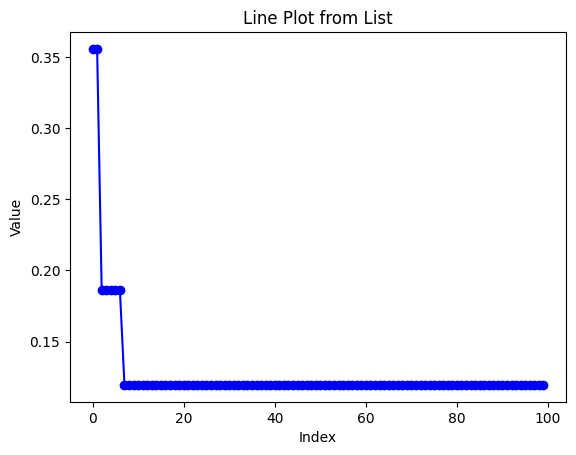

In [17]:
SEED = 40
random.seed(SEED)
np.random.seed(SEED)

POP_SIZE = 50
initial_population = []


for _ in range(POP_SIZE):
    players = [Player(row) for _, row in players_df.iterrows()]
    league = League(cycle_crossover, swap_mutation)
    league.draft_players(players)
    initial_population.append(league)

best_solution = genetic_algorithm(
    initial_population=initial_population,
    max_gen=100,
    selection_algorithm=fitness_proportionate_selection,
    maximization=False,
    mut_prob=0.1,
    verbose=False
)

print("Best solution:", best_solution)
print("Fitness:", best_solution[0].fitness())
print("Fitness List:", best_solution[1])


# Create a line plot
plt.plot(best_solution[1], marker='o', linestyle='-', color='b')

# Optional: Add labels and title
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Line Plot from List')

# Show the plot
plt.show()

# RUNNING LOTS OF TIMES

In [ ]:
SEED = 40
random.seed(SEED)
np.random.seed(SEED)

POP_SIZE = 50
GENERATIONS = 100

grid_params = {
    "crossover": [
        #{"function": cycle_crossover, "xo_prob": 0.2},   # SANTI
        #{"function": cycle_crossover, "xo_prob": 0.9},  #LEONOR
        #{"function": swap_crossover, "xo_prob": 0.2},   # GUSTAVO
        {"function": swap_crossover, "xo_prob": 0.9}    # MARTIM
    ],
    "mutation": [
        {"function": shift_mutation,"mut_prob": 0.1},
        {"function": shift_mutation,"mut_prob": 0.5},
        {"function": invertion_mutation,"mut_prob": 0.1},
        {"function": invertion_mutation,"mut_prob": 0.5},
        {"function": swap_mutation,"mut_prob": 0.1},
        {"function": swap_mutation,"mut_prob": 0.5}
    ],
    "selection": [
        {"function": fitness_proportionate_selection, "maximization": False},
        {"function": tournament_selection, "tournament_size": 3, "maximization": False},
        {"function": tournament_selection, "tournament_size": 6, "maximization": False}
    ],
    "elitism": [True, False]                       # ELETISM CONFIGS
}

fitness_dfs = {}

grid = list(itertools.product(grid_params["crossover"], grid_params["mutation"], grid_params["selection"], grid_params["elitism"]))
#grid = list(itertools.product(grid_params["crossover"], grid_params["mutation"], grid_params["selection"]))                     # ELETISM CONFIGS

print(f"Number of configs: {len(grid)}")


for crossover_cfg, mutation_cfg, selection_cfg, elitism in tqdm(grid):
            

    # Create empty dataframe for each configuration
    # Columns have the fitness in each generation, rows will have results for each run
    df = pd.DataFrame(columns=range(GENERATIONS)) # Shape will be 30 x 200

    # Get crossover and mutation functions and probabilities from the grid
    crossover_function = crossover_cfg["function"]
    xo_prob = crossover_cfg["xo_prob"]
    mutation_function = mutation_cfg["function"]
    mut_prob = mutation_cfg["mut_prob"]
    selection_function = selection_cfg["function"]
    if selection_function == tournament_selection:
        tournament_size = selection_cfg["tournament_size"]
    maximization = selection_cfg["maximization"]

    config_results = []

    for run_nr in tqdm(range(30)):



        initial_population = []

        for _ in range(POP_SIZE):
            players = [Player(row) for _, row in players_df.iterrows()]
            league = League(swap_crossover, swap_mutation)
            league.draft_players(players)
            initial_population.append(league)

        _, fitness_over_gens = genetic_algorithm(
            initial_population=initial_population,
            max_gen=GENERATIONS,
            selection_algorithm=fitness_proportionate_selection,
            maximization=False,
            mut_prob=0.1,
            verbose=False
        )
        config_results.append(fitness_over_gens)
        df.loc[run_nr] = fitness_over_gens

        selection_name = selection_function.__name__
        if selection_function == tournament_selection:
            selection_name += f"(k={selection_cfg['tournament_size']})"

        config_label = (
          f"{crossover_function.__name__}{xo_prob}_"
          f"{mutation_function.__name__}{mut_prob}_"
          f"{selection_name}"
          f"_elitism={elitism}"      # UNCOMMENT FOR ELETISM CONFIGS
        )

    #df.to_csv(f"results_santi/fitness_{config_label}.csv", index=False)   # SANTI
    #df.to_csv(f"results_leonor/fitness_{config_label}.csv", index=False)   # LEONOR
    #df.to_csv(f"results_gustavo/fitness_{config_label}.csv", index=False)    #GUSTAVO
    df.to_csv(f"results_martim/fitness_{config_label}.csv", index=False)   #MARTIM

    fitness_dfs[config_label] = df


Number of configs: 144


  7%|▋         | 10/144 [01:03<14:04,  6.30s/it]


KeyboardInterrupt: 